<a href="https://colab.research.google.com/github/atyant20039/RL-Project-MCAC/blob/master/Playing_Atari_Games_using_MC_over_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym[atari,accept-rom-license]

In [ ]:
import random
import tensorflow as tf
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from gym import envs
import matplotlib.pyplot as plt

In [ ]:
env = gym.make("MsPacman-v0")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment MsPacman-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

In [ ]:
state_size = (88, 80, 1)
action_size = env.action_space.n

In [ ]:
color = np.array([210, 164, 74]).mean()

def preprocess_state(state):

    #crop and resize the image
    image = state[1:176:2, ::2]

    #convert the image to greyscale
    image = image.mean(axis=2)

    #improve image contrast
    image[image==color] = 0

    #normalize the image
    image = (image - 128) / 128 - 1

    #reshape the image
    image = np.expand_dims(image.reshape(88, 80, 1), axis=0)

    return image

In [ ]:
gamma = 0.9

In [ ]:
class DQN:
    def __init__(self, state_size, action_size):

        #define the state size
        self.state_size = state_size

        #define the action size
        self.action_size = action_size

        #define the replay buffer
        self.replay_buffer = deque(maxlen=5000)

        #define the discount factor
        self.gamma = gamma

        #define the epsilon value
        self.epsilon = 0.8

        #define the update rate at which we want to update the target network
        self.update_rate = 1000

        #define the main network
        self.main_network = self.build_network()

        #define the target network
        self.target_network = self.build_network()

        #copy the weights of the main network to the target network
        self.target_network.set_weights(self.main_network.get_weights())


    #Let's define a function called build_network which is essentially our DQN.

    def build_network(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=4, padding='same', input_shape=self.state_size))
        model.add(Activation('relu'))

        model.add(Conv2D(64, (4, 4), strides=2, padding='same'))
        model.add(Activation('relu'))

        model.add(Conv2D(64, (3, 3), strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(Flatten())


        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam())

        return model

    #We learned that we train DQN by randomly sampling a minibatch of transitions from the
    #replay buffer. So, we define a function called store_transition which stores the transition information
    #into the replay buffer

    def store_transistion(self, st):
        self.replay_buffer.append(st)


    #We learned that in DQN, to take care of exploration-exploitation trade off, we select action
    #using the epsilon-greedy policy. So, now we define the function called epsilon_greedy
    #for selecting action using the epsilon-greedy policy.

    def epsilon_greedy(self, state):
        if random.uniform(0,1) < self.epsilon:
            return np.random.randint(self.action_size)

        Q_values = self.main_network.predict(state)

        return np.argmax(Q_values[0])


    #train the network
    def train(self, batch_size):

        #sample a mini batch of transition from the replay buffer
        minibatch = random.sample(self.replay_buffer, batch_size)

        #compute the Q value using the target network
        for state, action, reward, next_state, done, Q_mc_target in minibatch:
            if not done:
                target_Q = (reward + self.gamma * np.amax(self.target_network.predict(next_state)))
                target_Q = max(target_Q, Q_mc_target)
            else:
                target_Q = max(reward, Q_mc_target)

            #compute the Q value using the main network
            Q_values = self.main_network.predict(state)

            Q_values[0][action] = target_Q

            #train the main network
            self.main_network.fit(state, Q_values, epochs=1, verbose=0)

    #update the target network weights by copying from the main network
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())

In [ ]:
num_episodes = 5
num_timesteps = 250
batch_size = 8
num_screens = 4
dqn = DQN(state_size, action_size)

In [ ]:
done = False
time_step = 0
mean_return_ls = []
#for each episode
for i in range(num_episodes):

    #set return to 0
    Return = 0
    return_mc = 0
    n = 0
    episode_buffer = []
    #preprocess the game screen
    state = preprocess_state(env.reset())

    #for each step in the episode
    for t in range(num_timesteps):

        #render the environment
        env.render("rgb_array")

        #update the time step
        time_step += 1

        #update the target network
        if time_step % dqn.update_rate == 0:
            dqn.update_target_network()

        #select the action
        action = dqn.epsilon_greedy(state)

        #perform the selected action
        next_state, reward, done, _ = env.step(action)

        #preprocess the next state
        next_state = preprocess_state(next_state)

        #store the transition information
        #dqn.store_transistion(state, action, reward, next_state, done)
        episode_buffer.append((state, action, reward, next_state, done))

        #update current state to next state
        state = next_state

        #update the return

        Return += reward
        return_mc = gamma*return_mc + reward
        n += 1

        #if the episode is done then print the return
        if done:
            print('Episode: ',i, ',' 'Return', Return)
            break

        #if the number of transistions in the replay buffer is greater than batch size
        #then train the network
        if len(dqn.replay_buffer) > batch_size:
            dqn.train(batch_size)
    for traj in episode_buffer:
        Q_mc_target = return_mc/n
        traj += (Q_mc_target,)
        dqn.store_transistion(traj)
    print("Mean return =", Return/n)
    mean_return_ls.append(Return/n)

1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
Mean return = 0.52
1/1 [==============================] - 0s 23ms/step
Mean return = 0.36


In [ ]:
print(mean_return_ls)

[0.28, 0.4, 0.44, 0.52, 0.36]


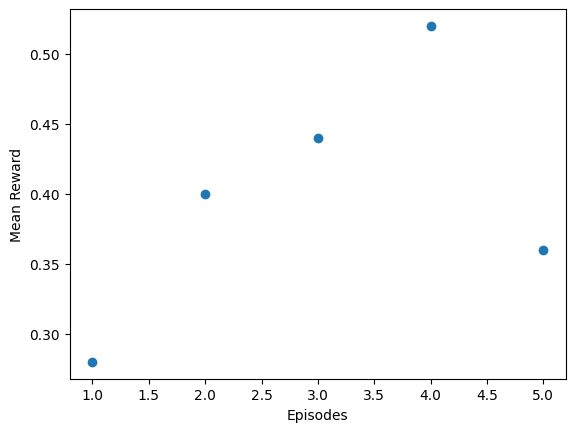

In [ ]:
x_axis = []
for i in range(len(mean_return_ls)):
    x_axis.append(i+1)
plt.scatter(x_axis, mean_return_ls)
plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.show()